In [1]:
%run ../_preamble.ipynb
from _work.src.modules import AutoEncoder, train_model, plot_metrics, plot_tensor, iterate
from _work.src.modules.utils import save_metrics, load_metrics, get_closest_item, get_distances
from _work.src.data import small_dataloader as dataloader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

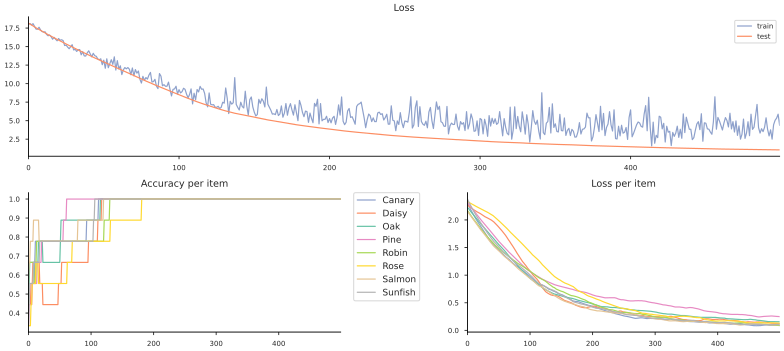

In [2]:
metrics = train_model(
    model := AutoEncoder(
        sizes=[dataloader.dataset.NUM_ATTRIBUTES, 32],
        batch_norm=False,
        dropout=0,
    ),
    optimizer := torch.optim.AdamW(model.parameters(), lr=1e-3),
    loss_fn := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=500,
    noise_mean=0,
    noise_stdev=1,
    noise_multiplier=0.5,
    l1_lambda=0.0005,
)

plot_metrics(metrics);

In [3]:
from functools import reduce
from colors import hex
import colour

def mix_colors(*colors):
    def perc(color, p):
        h, s, l = colour.RGB_to_HSL(colour.notation.HEX_to_RGB(color))
        _hex = colour.notation.RGB_to_HEX(colour.HSL_to_RGB([h, s, l * p]))
        return hex(_hex[1:])
    
    _colors = [perc(_hex, _p) for _hex, _p in colors]
    return [*map(lambda x: x/255, reduce(lambda a, b: a + b, _colors))]

In [4]:
from sklearn.decomposition import PCA
from itertools import combinations
from matplotlib import colors

@torch.no_grad()
@plt.style.context({
    "axes.xmargin": 0.06,
    "axes.ymargin": 0.06,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "figure.figsize": (7, 7)
})
def plot_grid(model, dataloader, n_components=2):
    model.eval()
    palette = {
        'Oak': '#B0E65A',
        'Pine': '#75993C',
        'Daisy': '#FEB756',
        'Rose': '#E6634E',
        'Salmon': '#9194E3',
        'Sunfish': '#8BCBD9',
        'Canary': '#FFD92F',
        'Robin': '#FF8C9A',
    }

    attractors = torch.vstack([model.encoder(x["y"]) for x in dataloader.dataset])
    if attractors.shape[1] > 2:
        pca = PCA(n_components=n_components)
        attractors = torch.tensor(pca.fit_transform(attractors))
        print(pca.explained_variance_ratio_)
    
    stuff = []
    for dim_a, dim_b in combinations(range(n_components), 2):
        aa = attractors[:, dim_a]
        bb = attractors[:, dim_b]
        center = [aa.mean(), bb.mean()]
        length = max(
            abs(aa.max() - aa.min()),
            abs(bb.max() - bb.min()),
        )

        resolution = 100
        arrow_stride = 4
        sl = slice(1, -1, arrow_stride)
        _a = np.linspace(-4, 4, num=resolution + 1)
        _b = np.linspace(-4, 4, num=resolution + 1)
        # _a = np.linspace(center[0] - length/1.5, center[0] + length/1.5, num=resolution + 1)
        # _b = np.linspace(center[1] - length/1.5, center[1] + length/1.5, num=resolution + 1)
        ag, bg = np.meshgrid(_a, _b)

        z, zx, zy = [], [], []
        for a, b in zip(ag.ravel(), bg.ravel()):
            activ = torch.zeros(n_components, dtype=torch.float32)
            activ[dim_a] = a
            activ[dim_b] = b

            if "pca" in locals():
                activ = torch.tensor(pca.inverse_transform(activ), dtype=torch.float32)

            y_pred = model.decoder(activ)
            item = get_closest_item(dataloader.dataset.df, y_pred, metric="euclidean")
            z.append(item[0])
        
            _, activations = iterate(model, initial_state=y_pred, runs=1, steps=10)
            final_activ = activations.squeeze()[-1].numpy()
            diff = np.subtract(final_activ, activ)

            if "pca" in locals():
                diff = pca.transform(diff.unsqueeze(dim=0))
                diff = diff.squeeze()

            zx.append(diff[0])
            zy.append(diff[1])
        
        classes = np.array([list(palette.keys()).index(x) for x in z]).reshape(ag.shape)
        zx, zy = np.array(zx).reshape(ag.shape), np.array(zy).reshape(bg.shape)
        things = [ag, bg, zx, zy, classes, sl, attractors[:, (dim_a, dim_b)]]
        stuff.append(things)
    
    cmap = colors.ListedColormap([*palette.values()])
    if not 'pca' in locals():
        pca = None
    return stuff, cmap, palette, pca
    # xs = attractors[:, 0]
    # ys = attractors[:, 1]
    # center = torch.mean(attractors, dim=0)
    # length = max(
    #     abs(xs.max() - xs.min()),
    #     abs(ys.max() - ys.min()),
    # )

    # resolution = 100
    # arrow_stride = 4
    # sl = slice(1, -1, arrow_stride)
    # _x = np.linspace(center[0] - length/1.5, center[0] + length/1.5, num=resolution + 1)
    # _y = np.linspace(center[1] - length/1.5, center[1] + length/1.5, num=resolution + 1)
    # xg, yg = np.meshgrid(_x, _y)

    # c = []
    # z, zx, zy = [], [], []
    # for x, y in zip(xg.ravel(), yg.ravel()):
    #     activ = torch.tensor([x, y], dtype=torch.float32)

    #     if "pca" in locals():
    #         activ = torch.tensor(pca.inverse_transform(activ), dtype=torch.float32)

    #     y_pred = model.decoder(activ)
    #     item = get_closest_item(dataloader.dataset.df, y_pred, metric="euclidean")
    #     z.append(item[0])

    #     # dists = get_distances(y_pred, dataloader.dataset.df, metric='euclidean')
    #     # # dists = [*map(lambda x: (x[0], 1 - x[1]), dists)]
    #     # dists = [*map(lambda x: (x[0], 1/x[1]), dists)]

    #     # def _norm(d):
    #     #     _total = sum(map(lambda x: x[1], d))
    #     #     return [*map(lambda x: (x[0], x[1] / _total), d)]
        
    #     # dists = _norm(dists)
    #     # # dists = _norm(dists[:3])
    #     # ffac = 0.9/dists[0][1]
    #     # dists = [(x[0], x[1]*ffac) for x in dists]
    #     # dists = dists[:4]
    #     # factors = [0.5, 0.3, 0.1, 0.05]
    #     # _c = mix_colors(*[(palette[x[0]], x[1]*factors[i]) for i, x in enumerate(dists)])
    #     # c.append(_c)

    #     _, activations = iterate(model, initial_state=y_pred, runs=1, steps=10)
    #     final_activ = activations.squeeze()[-1].numpy()
    #     diff = np.subtract(final_activ, activ)

    #     if "pca" in locals():
    #         diff = pca.transform(diff.unsqueeze(dim=0))
    #         diff = diff.squeeze()

    #     zx.append(diff[0])
    #     zy.append(diff[1])
    
    # classes = np.array([list(palette.keys()).index(x) for x in z]).reshape(xg.shape)
    
    # zx, zy = np.array(zx).reshape(xg.shape), np.array(zy).reshape(yg.shape)
    
    # return xg, yg, classes, cmap, zx, zy, sl, attractors, palette, c

# xg, yg, classes, cmap, zx, zy, sl, attractors, palette, c = plot_grid(model, dataloader)
stuff, cmap, palette, pca = plot_grid(model, dataloader, n_components=3)

[ 0.58082453  0.20964814  0.12322129]


In [5]:
@plt.style.context({
    "axes.xmargin": 0.06,
    "axes.ymargin": 0.06,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "figure.figsize": (7, 7),
})
def doit(ag, bg, zx, zy, classes, sl, attractors, old=False):
    # if old is True:
    plt.scatter(ag, bg, s=11, c=classes, cmap=cmap, alpha=0.3, edgecolors="none")
    # else:
    #     plt.scatter(xg, yg, s=40, c=c, alpha=0.3, edgecolors="none")
    plt.quiver(
        ag[sl, sl],
        bg[sl, sl],
        zx[sl, sl],
        zy[sl, sl],
        units='xy',
        alpha=0.6,
    )

    for i, item in enumerate(attractors):
        plt.scatter(
            item[0],
            item[1],
            color=palette[dataloader.dataset.df.index[i]],
            edgecolors="black",
            marker="*",
            alpha=0.75,
            s=140,
        )
    
    plt.tick_params(axis='both', labelsize=9)
    plt.xlabel("First hidden dimension", fontsize=9)
    plt.ylabel("Second hidden dimension", fontsize=9)
    # plt.savefig('../plots/1_under_2_attr')

In [6]:
from matplotlib.patches import Patch
from matplotlib import gridspec

with plt.style.context({
    "axes.xmargin": 0.06,
    "axes.ymargin": 0.06,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "figure.figsize": (7, 7),
}):
    fig = plt.figure(figsize=(12, 3.5))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.1])

    ax0 = fig.add_subplot(gs[0])
    plt.sca(ax0)
    doit(*stuff[0])
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    ax1 = fig.add_subplot(gs[1])
    plt.sca(ax1)
    doit(*stuff[1])
    plt.xlabel("PC1")
    plt.ylabel("PC3")

    ax2 = fig.add_subplot(gs[2])
    plt.sca(ax2)
    doit(*stuff[2])
    plt.xlabel("PC2")
    plt.ylabel("PC3")

    legend_elements = [Patch(facecolor=color, label=item) for item, color in palette.items()]
    legend_ax = fig.add_subplot(gs[3])
    legend_ax.axis("off")
    legend_ax.legend(
        handles=legend_elements,
        borderaxespad=0,
        loc="upper right",
        bbox_to_anchor=[0, 0, 1, 1],
        fontsize=9,
    )

    plt.tight_layout()
    plt.savefig('../plots/1_over_32_attr_grid_triplet_legend_2')

In [133]:
from _work.src.modules.replay import get_attractors

(attrs, counts), (activs, counts) = get_attractors(model, runs=500, burn_in_time=25, steps=50, round=True, decimals=4)
attrs, counts

(tensor([[0.0267, 0.9774, 0.7085, 0.0266, 0.6287, 0.1710, 0.9724, 0.0392, 0.3232],
         [0.5742, 0.9852, 0.0471, 0.9466, 0.0610, 0.2468, 0.0584, 0.3442, 0.7046]]),
 array([1580,    7]))

In [134]:
activs

tensor([[0.2028, 1.7347, 0.0000, 1.5705, 0.0365, 0.8878, 0.5735, 1.3331, 0.6875,
         1.1194, 0.2198, 0.0000, 0.0000, 0.1163, 0.2522, 0.0000, 0.5524, 0.0000,
         1.2821, 1.1812, 1.2552, 0.7957, 0.3650, 1.4136, 0.0256, 0.5848, 0.2402,
         0.0000, 0.4126, 0.5736, 0.6663, 0.0000],
        [0.0000, 0.1927, 1.1175, 0.0260, 1.3025, 0.1117, 0.9451, 0.0000, 0.4591,
         1.3407, 1.3095, 0.7520, 0.7051, 1.0994, 0.2745, 1.2648, 0.3895, 0.5625,
         0.0862, 0.9817, 0.2906, 0.8079, 0.1166, 0.2729, 0.8215, 0.4043, 0.6664,
         0.9508, 0.6939, 0.3872, 1.3156, 0.4150]])

In [135]:
pca.transform(activs)

array([[ 2.56979781, -0.2568484 ,  0.03170195],
       [-2.00852679, -0.92621483, -0.31549463]])